# Предсказать, зарабатывает ли человек более 50 тыс. долларов в год, на основе предоставленных признаков

# Описание
Датасет "Adult" содержит информацию о различных атрибутах людей, которые были собраны из переписи населения США. Данные содержат 14 полей, включая информацию о возрасте, работе, образовании, семейном положении, расе, поле, родном стране и заработной плате.
В датасете представлены следующие признаки:

- age: возраст субъекта исследования
- workclass: класс работы, который может включать такие значения, как "частный сектор", "государственный сектор", "безработный" и другие
- fnlwgt: вес наблюдения, используемый для корректного представления общей популяции
- education: уровень образования субъекта, например, "среднее", "высшее"
- educational-num: числовое представление уровня образования
- marital-status: семейное положение субъекта, такое как "женат/замужем", "разведен/разведена"
- occupation: род деятельности субъекта, например, "техник", "продавец"
- relationship: отношения субъекта, например, "супруг/супруга", "друг/подруга"
- race: расовая принадлежность субъекта, такая как "белая", "черная", "азиатская"
- gender: пол субъекта, такой как "мужской", "женский"
- capital-gain: капиталовыручка субъекта
- capital-loss: капиталотраты субъекта
- hours-per-week: количество часов, которые субъект работает в неделю
- native-country: страна, в которой родился субъект
- income: доход субъекта, обычно разделен на две категории, например, "больше 50K" и "меньше или равно 50K"

In [226]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance
import warnings

## 1. Загрузка датасета Adult.csv

In [227]:
df = pd.read_csv("adult.csv", encoding="latin1")
display(df.head())
display(df.shape)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


(48842, 15)

## 2. Типы данных и наличие пропущенных значений

In [228]:
display(df.info())
display(df.describe())
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


None

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


,0
age,0
workclass,0
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,0
relationship,0
race,0
gender,0


## 3. Преобразовать категориальные признаки в числовые значения с помощью кодирования, например, с помощью метода One-Hot Encoding.

In [229]:
target_col = 'income'
categorical_cols = df.select_dtypes(include=['object']).columns.drop(target_col).tolist()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

ohe = OneHotEncoder(handle_unknown='ignore')
preprocessor_ohe = ColumnTransformer([
    ('ohe', ohe, categorical_cols)
], remainder='passthrough')

## 4. Масштабировать числовые признаки, например, с помощью метода StandardScaler.

In [230]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

## 5. Разделить данные на обучающую и тестовую выборки.

In [231]:
df[target_col] = df[target_col].str.strip()
y = (df[target_col].str.contains('>50K')).astype(int)
X = df.drop(columns=[target_col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (36631, 14) Test shape: (12211, 14)


## 6. Построить диаграмму для отображения баланса классов в целевой переменной (зарабатывает более 50 тыс. долларов в год или нет).

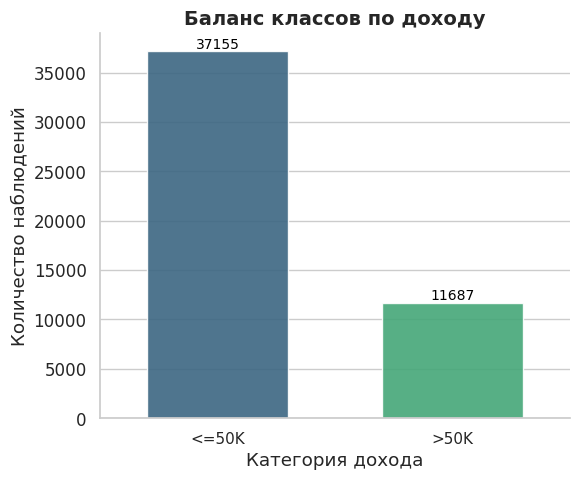

In [232]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(
    x=y,
    hue=y,
    palette='viridis',
    alpha=0.9,
    width=0.6,
    legend=False
)
plt.xticks([0, 1], ['<=50K', '>50K'], fontsize=11)
plt.title('Баланс классов по доходу', fontsize=14, fontweight='bold')
plt.ylabel('Количество наблюдений')
plt.xlabel('Категория дохода')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', fontweight='medium')

sns.despine()
plt.tight_layout()
plt.show()

## 7. Построить матрицу корреляции между числовыми признаками для выявления возможной зависимости между ними.

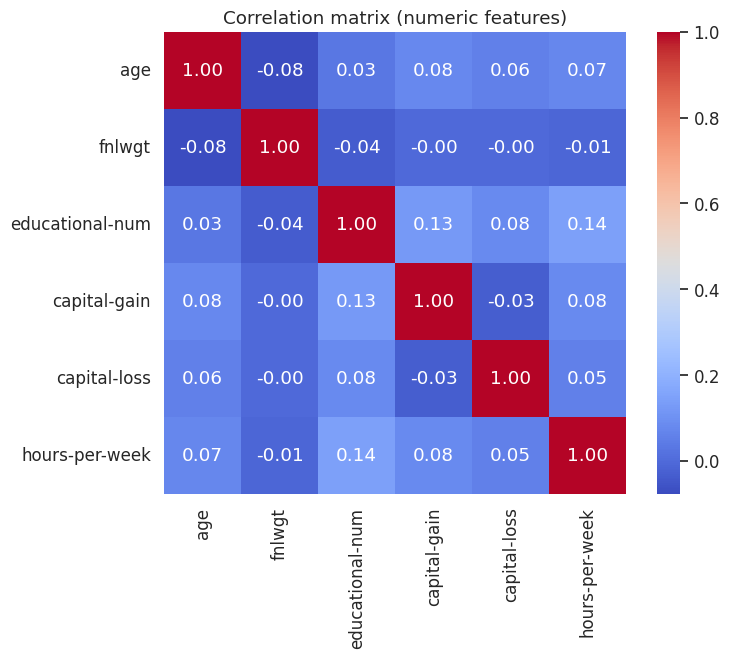

In [233]:
num_df = df[numeric_cols]
corr = num_df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation matrix (numeric features)')
plt.show()

## 8. Построить гистограмму распределения возраста в зависимости от значения целевой переменной.

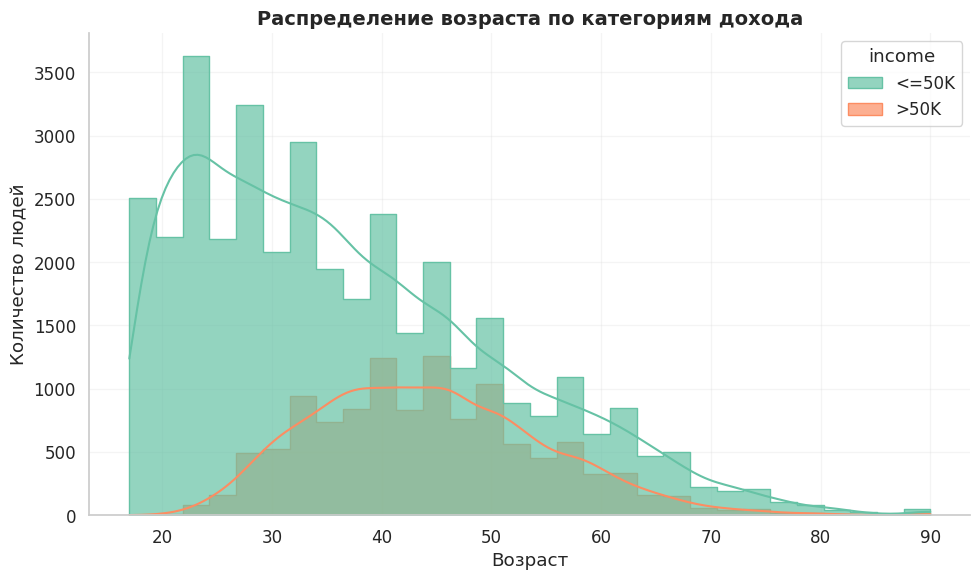

In [234]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='age', hue=target_col, bins=30, kde=True,
             palette='Set2', alpha=0.7, element='step')
plt.title('Распределение возраста по категориям дохода', fontsize=14, fontweight='bold')
plt.xlabel('Возраст')
plt.ylabel('Количество людей')
plt.grid(alpha=0.2)
sns.despine()
plt.tight_layout()
plt.show()

## 9. Выбрать алгоритм классификации, например, Random Forest.

In [235]:
rf_pipeline = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

## 10. Обучить модель на обучающей выборке и оценить ее точность на тестовой выборке с помощью метрик, таких как Accuracy, Precision, Recall, F1-score.

In [236]:
rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)
y_proba = rf_pipeline.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8571779543034969
Precision: 0.7382686084142395
Recall: 0.6245722108145106
F1-score: 0.6766777901371894
ROC AUC: 0.9028445028817951

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      9289
           1       0.74      0.62      0.68      2922

    accuracy                           0.86     12211
   macro avg       0.81      0.78      0.79     12211
weighted avg       0.85      0.86      0.85     12211



## 11. Оценить важность признаков с помощью алгоритма и вывести их значения в виде графика.

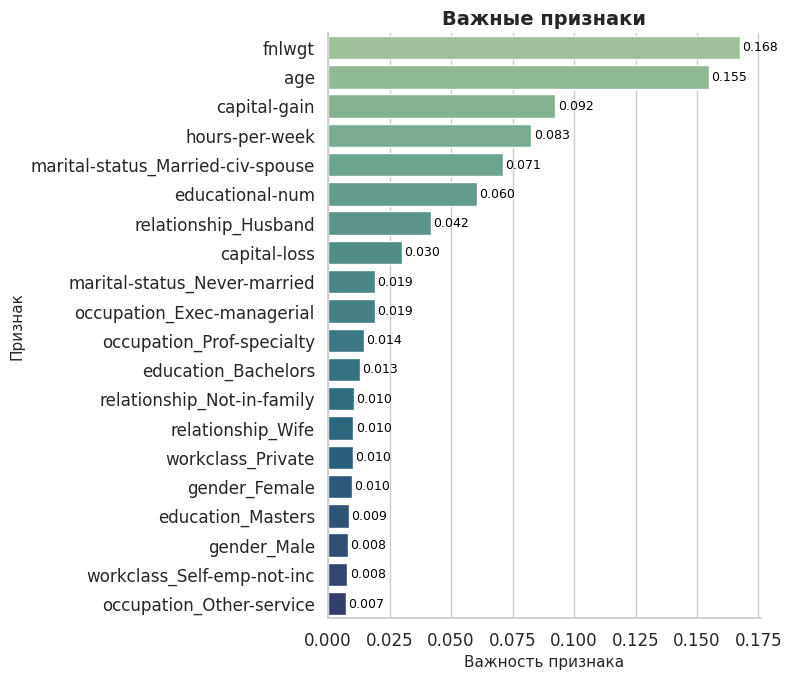

In [237]:
preprocessor.fit(X_train)

cat_ohe = preprocessor.named_transformers_['cat']
cat_feature_names = cat_ohe.get_feature_names_out(categorical_cols).tolist()

feature_names = numeric_cols + cat_feature_names

importances = rf_pipeline.named_steps['clf'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 7))
ax = sns.barplot(
    x=feat_imp.values,
    y=feat_imp.index,
    hue=feat_imp.index,
    palette='crest',
    legend=False
)
plt.title('Важные признаки', fontsize=14, fontweight='bold')
plt.xlabel('Важность признака', fontsize=11)
plt.ylabel('Признак', fontsize=11)

for i, v in enumerate(feat_imp.values):
    ax.text(v + 0.001, i, f"{v:.3f}", color='black', va='center', fontsize=9)

sns.despine()
plt.tight_layout()
plt.show()

## 12. Применить метод GridSearchCV для поиска оптимальных гиперпараметров модели.

In [225]:
param_grid = {
    'clf__n_estimators': [50, 70, 100],
    'clf__max_depth': [5, 7, 10],
    'clf__min_samples_split': [2, 5],
    'clf__class_weight': ['balanced', None]
}

gs = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV score (f1):", gs.best_score_)

best_rf = gs.best_estimator_
y_pred_gs = best_rf.predict(X_test)
y_proba_gs = best_rf.predict_proba(X_test)[:,1]
print("Test F1:", f1_score(y_test, y_pred_gs))
print("Test Accuracy:", accuracy_score(y_test, y_pred_gs))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba_gs))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best params: {'clf__class_weight': 'balanced', 'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best CV score (f1): 0.6690474429935201
Test F1: 0.6676188003116074
Test Accuracy: 0.7903529604455
Test ROC AUC: 0.9056745523931548


## 13. Повторить шаги 9-12 для других алгоритмов классификации и сравнить их между собой.

Сравнение моделей:


,Model,Accuracy,Precision,Recall,F1,ROC AUC
2,GradientBoosting,0.867578,0.796996,0.599247,0.684118,0.920349
1,LogisticRegression,0.809762,0.569281,0.842231,0.679365,0.906357
0,RandomForest (GridSearch),0.790353,0.537866,0.879877,0.667619,0.905675


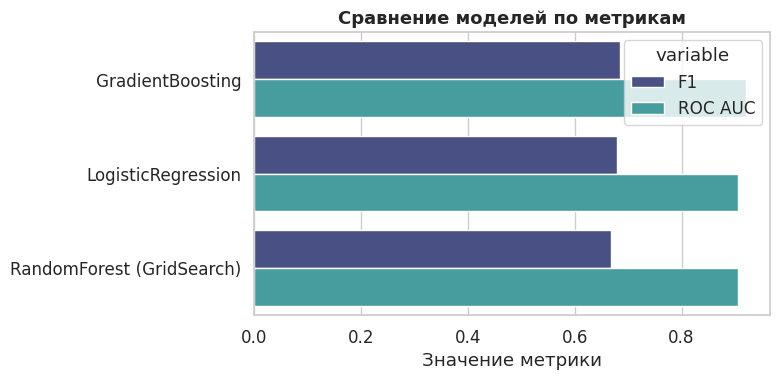

In [222]:
models = {
    "RandomForest (GridSearch)": best_rf,
    "LogisticRegression": Pipeline([
        ('preproc', preprocessor),
        ('clf', LogisticRegression(max_iter=1000, n_jobs=-1, class_weight='balanced'))
    ]),
    "GradientBoosting": Pipeline([
        ('preproc', preprocessor),
        ('clf', GradientBoostingClassifier(random_state=42))
    ])
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None
    })

results_df = pd.DataFrame(results).sort_values(by="F1", ascending=False)
print("Сравнение моделей:")
display(results_df)
plt.figure(figsize=(8,4))
sns.barplot(data=results_df.melt(id_vars="Model", value_vars=["F1", "ROC AUC"]),
            x="value", y="Model", hue="variable", palette="mako")
plt.title("Сравнение моделей по метрикам", fontsize=13, fontweight='bold')
plt.xlabel("Значение метрики")
plt.ylabel("")
plt.tight_layout()
plt.show()


## 14. Выбрать лучшую модель и сделать предсказание на новых данных.

In [223]:
best_name = results_df.iloc[0]["Model"]
print(f"\nЛучшая модель: {best_name}")

best_model = models[best_name]

new_data = pd.DataFrame([{
    'age': 30, 'workclass':'Private', 'fnlwgt':200000, 'education':'Bachelors', 'educational-num':13,
    'marital-status':'Never-married', 'occupation':'Sales', 'relationship':'Not-in-family',
    'race':'White', 'gender':'Male', 'capital-gain':0, 'capital-loss':0, 'hours-per-week':40,
    'native-country':'United-States'
}])

prediction = best_model.predict(new_data)[0]
proba = best_model.predict_proba(new_data)[0,1]
print(f"\nПрогноз: {'>50K' if prediction==1 else '<=50K'} (вероятность {proba:.2f})")


Лучшая модель: GradientBoosting

Прогноз: <=50K (вероятность 0.06)


## 15. Оценить качество модели на основе полученных предсказаний с помощью метрик.

In [224]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("=== Финальные метрики на тестовой выборке ===")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"ROC AUC:   {roc_auc:.3f}\n")

print("=== Выводы о качестве модели ===")

# Accuracy
if accuracy > 0.85:
    print("- Accuracy высокий: модель правильно классифицирует большинство наблюдений.")
else:
    print("- Accuracy средний или низкий: модель ошибается чаще, чем хотелось бы.")

# Precision
if precision > 0.75:
    print(f"- Precision хороший ({precision:.2f}): прогнозируемый доход >50K верен в большинстве случаев.")
else:
    print(f"- Precision низкий ({precision:.2f}): много ложноположительных предсказаний.")

# Recall
if recall > 0.7:
    print(f"- Recall хороший ({recall:.2f}): модель находит большинство высокозарабатывающих.")
else:
    print(f"- Recall низкий ({recall:.2f}): модель пропускает часть высокозарабатывающих.")

# F1-score
print(f"- F1-score ({f1:.2f}) показывает сбалансированное сочетание Precision и Recall.")

# ROC AUC
if roc_auc > 0.9:
    print(f"- ROC AUC высокий ({roc_auc:.2f}): модель отлично различает классы по вероятности.")
else:
    print(f"- ROC AUC ниже 0.9 ({roc_auc:.2f}): различение классов можно улучшить.")


=== Финальные метрики на тестовой выборке ===
Accuracy:  0.868
Precision: 0.797
Recall:    0.599
F1-score:  0.684
ROC AUC:   0.920

=== Выводы о качестве модели ===
- Accuracy высокий: модель правильно классифицирует большинство наблюдений.
- Precision хороший (0.80): прогнозируемый доход >50K верен в большинстве случаев.
- Recall низкий (0.60): модель пропускает часть высокозарабатывающих.
- F1-score (0.68) показывает сбалансированное сочетание Precision и Recall.
- ROC AUC высокий (0.92): модель отлично различает классы по вероятности.
